In [122]:
import pandas as pd
print(pd.__version__) # cheack version pandas

2.2.2


In [123]:
import tensorflow as tf
print(tf.__version__) # check version tensorflow

2.17.0


ขั้นตอนที่ 1 คือ การอ่านข้อมูลด้วย pandas เเละ เช็คว่าข้อมูลสูญหาย หรือ missing data หรือเปล่า

In [125]:
import pandas as pd

# เป็นการ read data เเละเช็คว่าข้อใูลครบไหม มี missing หรือ เปล่า มีข้อมูลสูญหายหรือเปล่า
df = pd.read_excel("simulated_flood_data_1month.xlsx")
print(df.head())
print(df.info()) # ดูว่ามี missing (NaN) หรือไม่


            timestamp  rain  water_level
0 2024-09-01 00:00:00     0        0.000
1 2024-09-01 00:01:00     1        0.025
2 2024-09-01 00:02:00     0        0.010
3 2024-09-01 00:03:00     0        0.000
4 2024-09-01 00:04:00     0        0.000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43200 entries, 0 to 43199
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    43200 non-null  datetime64[ns]
 1   rain         43200 non-null  int64         
 2   water_level  43200 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1012.6 KB
None


In [126]:
print(df.isnull().sum()) # ตรวจสอบว่ามีข้อมูลสูญหายหรือป่าว

timestamp      0
rain           0
water_level    0
dtype: int64


❓ Missing Data คืออะไร?
Missing data (ข้อมูลที่ขาดหาย) คือ ค่าที่หายไปหรือว่างเปล่า ในชุดข้อมูล — ซึ่งอาจเกิดจาก:

ไม่มีการบันทึกค่าตอนนั้น

เครื่องมือวัดเสีย

ข้อมูลสูญหายระหว่างการเก็บหรือส่ง

มีค่าที่ไม่สามารถวัดได้จริง ๆ

ถ้ามี missing value จะมีคำว่า NaN ขั้นใน เเถวนั้น

In [129]:
data = df.sort_values('timestamp').reset_index(drop=True).copy()
data

,timestamp,rain,water_level
0,2024-09-01 00:00:00,0,0.000
1,2024-09-01 00:01:00,1,0.025
2,2024-09-01 00:02:00,0,0.010
3,2024-09-01 00:03:00,0,0.000
4,2024-09-01 00:04:00,0,0.000
...,...,...,...
43195,2024-09-30 23:55:00,0,0.040
43196,2024-09-30 23:56:00,0,0.025
43197,2024-09-30 23:57:00,0,0.010
43198,2024-09-30 23:58:00,0,0.000


In [130]:
df[['timestamp','rain','water_level']]
df.columns=['date','x','y']
df

,date,x,y
0,2024-09-01 00:00:00,0,0.000
1,2024-09-01 00:01:00,1,0.025
2,2024-09-01 00:02:00,0,0.010
3,2024-09-01 00:03:00,0,0.000
4,2024-09-01 00:04:00,0,0.000
...,...,...,...
43195,2024-09-30 23:55:00,0,0.040
43196,2024-09-30 23:56:00,0,0.025
43197,2024-09-30 23:57:00,0,0.010
43198,2024-09-30 23:58:00,0,0.000


ขั้นตอนที่ 2 แปลง timestamp และตั้ง index (optional แต่ช่วยให้วิเคราะห์ง่าย)

In [132]:
# แปลง timestamp และตั้ง index (optional แต่ช่วยให้วิเคราะห์ง่าย)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True) #จะทำให้คอลัมน์ timestamp กลายเป็น index ของ DataFrame                                     
#การตั้งค่า inplace=True หมายความว่าเราต้องการให้การเปลี่ยนแปลงนี้เกิดขึ้นโดยตรงกับ DataFrame เดิม โดยไม่ต้องสร้าง DataFrame ใหม่

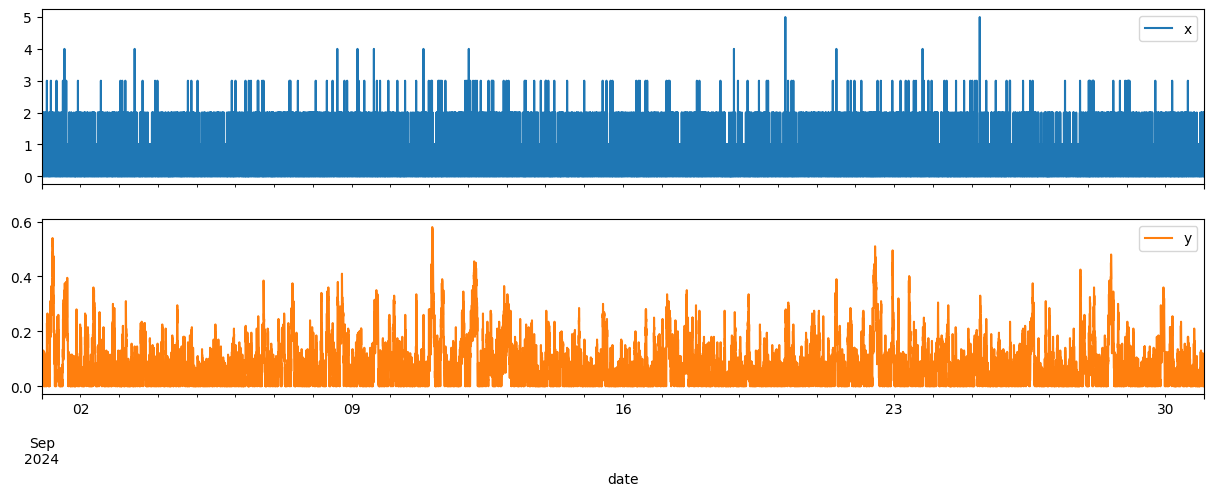

In [133]:
#  วิเคราะห์ข้อมูลเบื้องต้น (EDA) ด้วย matplotlib
df[['x', 'y']].plot(subplots=True, figsize=(15,5))
plt.show()

Normalize ข้อมูลให้มีค่า [0,-1]

In [141]:
from sklearn.preprocessing import MinMaxScaler

# Normalize data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['x', 'y']]) # ทำการ Normalize data ที่ใช้ คือ rain เเละ water_level

ขั้นตอนนี้เป็นขั้นตอนที่ สำคัญที่สุด คือการเตรียมข้อมูล Time series เพื่อนำไปใช้ใน model LSTM

In [149]:
import numpy as np

def create_sequences(data, time_steps=60, predict_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps - predict_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps + predict_steps - 1, 1])  # column 1 = water_level
    return np.array(X), np.array(y)

X, y = create_sequences(scaled, time_steps=60, predict_steps=10)

In [151]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, input_shape=(60, 2)),  # 60 time steps, 2 features
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=10, batch_size=32)


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0100
Epoch 2/10
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0084
Epoch 3/10
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0084
Epoch 4/10
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0083
Epoch 5/10
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0083
Epoch 6/10
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0083
Epoch 7/10
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0084
Epoch 8/10
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0082
Epoch 9/10
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0083
Epoch 10/10
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0083


In [185]:
# สมมุติว่าเรามี scaled test data แล้ว (อาจเป็นส่วนท้ายของข้อมูล)
X_test = scaled[-30:]  # เลือก 60 นาทีล่าสุด

# ต้อง reshape ให้เป็น (1, 60, 2) → 1 sample, 60 time steps, 2 features
X_test = X_test.reshape(1,30, 2)


In [187]:
y_pred = model.predict(X_test)

print(y_pred[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
0.058375973
